In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

# Setup

In [44]:
# Lengths of the BBO crystals

## Real lengths
L_BBO_PRE = 12.5e3
L_BBO_POST = 13.3e3

# ## Paper lengths
# L_BBO_PRE = 13e3
# L_BBO_POST = 13.76e3

# Orientation of the YVO4 crystals
# Pre compensating crystal shows 'a' ('aprime') axis to H (V) polarised pump light
# Post compensating crystal shows 'b' ('bprime') axis to VV (HH) polarised signal/idler light (from H (V) polarised pump)
a = "o"
aprime = "e"
b = "e"
bprime = "o"

# Wavelength dependent range
min_pump_wavelength = 404.8e-3
max_pump_wavelength = 405.2e-3

min_signal_wavelength = 780e-3
max_signal_wavelength = 830e-3

# Purchased lengths of YVO4 crystals
purchased_length_pre = 690
purchased_length_post = 800

# Sellmeiers

Using Eimerl and Shi for the Sellmeier equations

## BBO

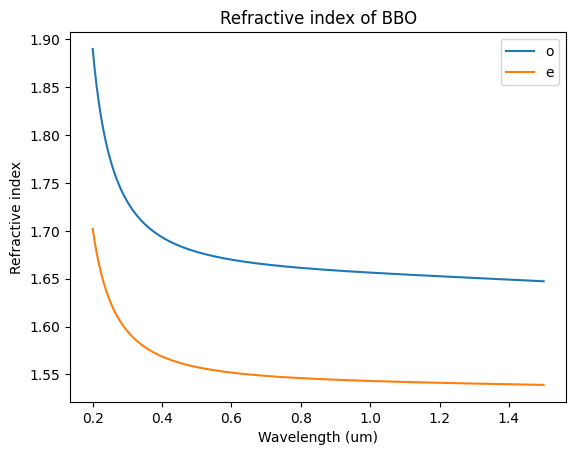

In [45]:
def bbo_sellmeier_n(wavelength, axis="o"):
    """
    Sellmeier equation for BBO crystal
    https://refractiveindex.info
    Eimerl et al., 1987
    """
    if axis == "o":
        A = 2.7405
        B = 0.0184
        C = 0.0179
        D = 0.0155
    elif axis == "e":
        A = 2.3730
        B = 0.0128
        C = 0.0156
        D = 0.0044

    n2 = A + B / (wavelength**2 - C) - D * wavelength**2
    return np.sqrt(n2)


# plot the refractive index of BBO
wavelength = np.linspace(0.2, 1.5, 1000)
n_o = bbo_sellmeier_n(wavelength, "o")
n_e = bbo_sellmeier_n(wavelength, "e")
plt.plot(wavelength, n_o)
plt.plot(wavelength, n_e)
plt.legend(["o", "e"])
plt.xlabel("Wavelength (um)")
plt.ylabel("Refractive index")
plt.title("Refractive index of BBO")
plt.show()

In [46]:
def bbo_sellmeier_n_eff(wavelength, theta=np.pi / 4):
    """
    Effective refractive index of BBO
    """
    no = bbo_sellmeier_n(wavelength, "o")
    ne = bbo_sellmeier_n(wavelength, "e")
    n = 1 / np.sqrt(np.sin(theta) ** 2 / no**2 + np.cos(theta) ** 2 / ne**2)
    return n

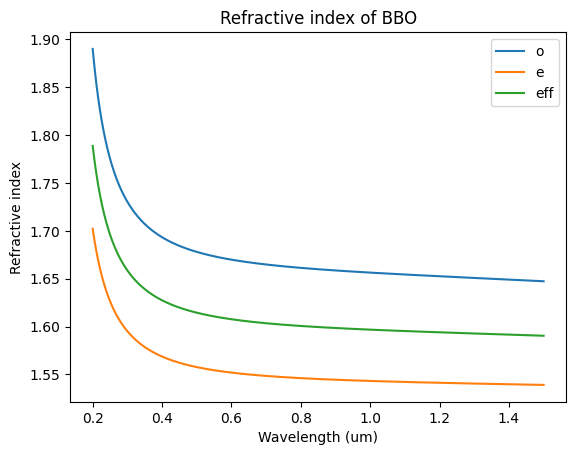

In [47]:
# plot the refractive index of BBO
wavelength = np.linspace(0.2, 1.5, 1000)
n_o = bbo_sellmeier_n(wavelength, "o")
n_e = bbo_sellmeier_n(wavelength, "e")
n_eff = bbo_sellmeier_n_eff(wavelength)
plt.plot(wavelength, n_o)
plt.plot(wavelength, n_e)
plt.plot(wavelength, n_eff)
plt.legend(["o", "e", "eff"])
plt.xlabel("Wavelength (um)")
plt.ylabel("Refractive index")
plt.title("Refractive index of BBO")
plt.show()

## YVO4

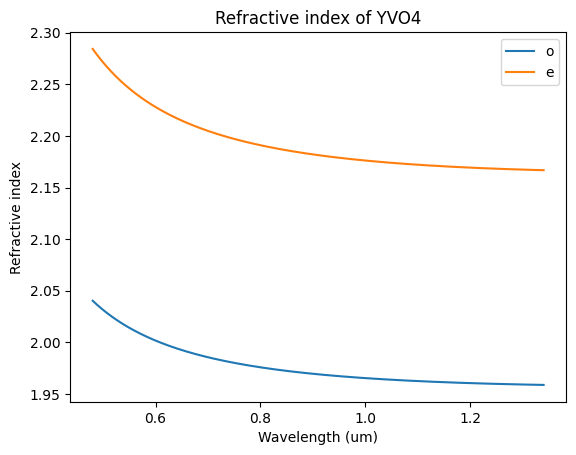

In [48]:
def yvo_sellmeier_n(wavelength, axis="o"):
    """
    Sellmeier equation for YVO4 crystal
    https://refractiveindex.info
    Shi et al. (2001) (20 °C)
    """
    if axis == "o":
        A = 3.778790
        B = 0.070479
        C = 0.045731
        D = -0.009701
    elif axis == "e":
        A = 4.607200
        B = 0.108087
        C = 0.052495
        D = -0.014305
    n2 = A + B / (wavelength**2 - C) - D * wavelength**2
    return np.sqrt(n2)


# plot the refractive index of YVO4
wavelength = np.linspace(0.48, 1.34, 1000)
n_o = yvo_sellmeier_n(wavelength, "o")
n_e = yvo_sellmeier_n(wavelength, "e")
plt.plot(wavelength, n_o)
plt.plot(wavelength, n_e)
plt.legend(["o", "e"])
plt.xlabel("Wavelength (um)")
plt.ylabel("Refractive index")
plt.title("Refractive index of YVO4")
plt.show()

# Phase difference definition

In [49]:
def get_phase_differences(
    pump_wavelengths,
    i_wavelengths,
    a,
    b,
    aprime,
    bprime,
    l_yvo_pre,
    L_BBO_PRE,
    L_BBO_POST,
    l_yvo_post,
):
    X, Y = np.meshgrid(i_wavelengths, pump_wavelengths)

    phases = np.zeros_like(X)
    wavelength_dependent_phase_range = np.zeros_like(X)

    for i, pump_wavelength in enumerate(pump_wavelengths):
        s_wavelengths = 1 / (1 / pump_wavelength - 1 / i_wavelengths)

        n_a_yvo_p = yvo_sellmeier_n(pump_wavelength, a)
        n_o_bbo_p = bbo_sellmeier_n(pump_wavelength, "o")
        n_eff_bbo_i = bbo_sellmeier_n_eff(i_wavelengths)
        n_eff_bbo_s = bbo_sellmeier_n_eff(s_wavelengths)
        n_b_yvo_i = yvo_sellmeier_n(i_wavelengths, b)
        n_b_yvo_s = yvo_sellmeier_n(s_wavelengths, b)
        n_aprime_yvo_p = yvo_sellmeier_n(pump_wavelength, aprime)
        n_eff_bbo_p = bbo_sellmeier_n_eff(pump_wavelength)
        n_o_bbo_i = bbo_sellmeier_n(i_wavelengths, "o")
        n_o_bbo_s = bbo_sellmeier_n(s_wavelengths, "o")
        n_bprime_yvo_i = yvo_sellmeier_n(i_wavelengths, bprime)
        n_bprime_yvo_s = yvo_sellmeier_n(s_wavelengths, bprime)

        phase_h = (
            2
            * np.pi
            * (
                l_yvo_pre * n_a_yvo_p / pump_wavelength
                + L_BBO_PRE * n_o_bbo_p / pump_wavelength
                + L_BBO_POST * n_eff_bbo_i / i_wavelengths
                + L_BBO_POST * n_eff_bbo_s / s_wavelengths
                + l_yvo_post * n_b_yvo_i / i_wavelengths
                + l_yvo_post * n_b_yvo_s / s_wavelengths
            )
        )

        phase_v = (
            2
            * np.pi
            * (
                l_yvo_pre * n_aprime_yvo_p / pump_wavelength
                + L_BBO_PRE * n_eff_bbo_p / pump_wavelength
                + L_BBO_POST * n_o_bbo_i / i_wavelengths
                + L_BBO_POST * n_o_bbo_s / s_wavelengths
                + l_yvo_post * n_bprime_yvo_i / i_wavelengths
                + l_yvo_post * n_bprime_yvo_s / s_wavelengths
            )
        )
        phases[i, :] = phase_v - phase_h

    wavelength_dependent_phase_range = phases.max() - phases.min()

    return abs(phases), wavelength_dependent_phase_range

# Absolute phase

Choosing the absolute phase difference between V (-> HH) and H (-> VV) incident photons to be zero enforces an affine length relationship between the pre- and post- compensating YVO4 crystals.

## Uncompensated

In [50]:
pre_comp_length = 0
post_comp_length = 0

pump_wavelength = np.array([0.405]) # central
i_wavelength = np.array([0.810]) # central

absolute_phase, wavelength_dependent_phase_range = get_phase_differences(
    pump_wavelengths = pump_wavelength,
    i_wavelengths = i_wavelength,
    a = a,
    b = b,
    aprime = aprime,
    bprime = bprime,
    l_yvo_pre = pre_comp_length,
    L_BBO_PRE = L_BBO_PRE,
    L_BBO_POST = L_BBO_POST,
    l_yvo_post = post_comp_length,
)

absolute_phase, wavelength_dependent_phase_range

(array([[233.77242435]]), np.float64(0.0))

Uncompensated set up has 233rad phase difference in the two arms

## Setting to zero

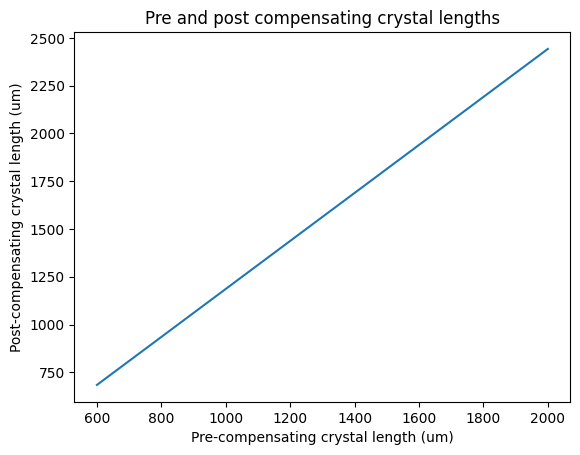

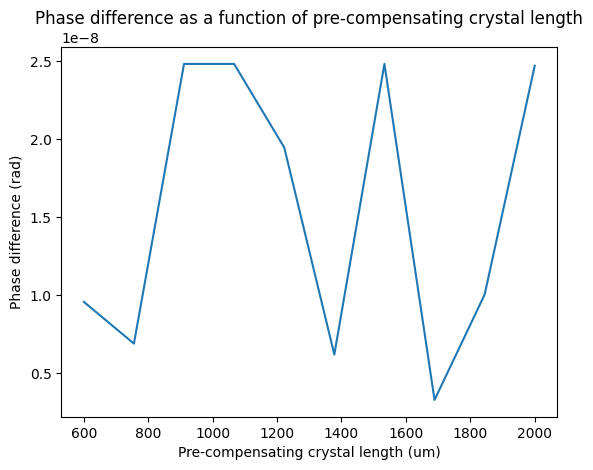

In [51]:
pre_comp_lengths = np.linspace(600, 2e3, 10)  # 0 to 20 mm
post_comp_lengths = np.zeros_like(pre_comp_lengths)
absolute_phase = np.zeros_like(pre_comp_lengths)

pump_wavelengths = np.array([0.405]) # central
i_wavelengths = np.array([0.810]) # central

for i, pre_comp_length in enumerate(pre_comp_lengths):
    # find the post compensating crystal length that minimises the phase difference using an optimisation algorithm
    def objective(post_comp_length):
        absolute_phase, wavelength_dependent_phase_range = get_phase_differences(
            pump_wavelengths=pump_wavelengths,
            i_wavelengths=i_wavelengths,
            a=a,
            b=b,
            aprime=aprime,
            bprime=bprime,
            l_yvo_pre=pre_comp_length,
            L_BBO_PRE=L_BBO_PRE,
            L_BBO_POST=L_BBO_POST,
            l_yvo_post=post_comp_length,
        )
        return absolute_phase

    res = minimize(objective, 2e3)
    post_comp_lengths[i] = res.x[0]
    absolute_phase[i] = res.fun


# plot the pre and post compensating crystal lengths
plt.plot(pre_comp_lengths, post_comp_lengths)
plt.xlabel("Pre-compensating crystal length (um)")
plt.ylabel("Post-compensating crystal length (um)")
plt.title("Pre and post compensating crystal lengths")
plt.show()

# plot the phase difference as a function of the pre-compensating crystal length

plt.plot(pre_comp_lengths, absolute_phase)
plt.xlabel("Pre-compensating crystal length (um)")
plt.ylabel("Phase difference (rad)")
plt.title("Phase difference as a function of pre-compensating crystal length")
plt.show()

In [52]:
# get the line of best fit
coefficients = np.polyfit(pre_comp_lengths, post_comp_lengths, 1)
line = np.polyval(coefficients, pre_comp_lengths)

print(f"Post-compensating crystal length = {coefficients[0]:.4f} * pre-compensating crystal length + {coefficients[1]:.2f}")

Post-compensating crystal length = 1.2564 * pre-compensating crystal length + -70.12


# Wavelength Dependence

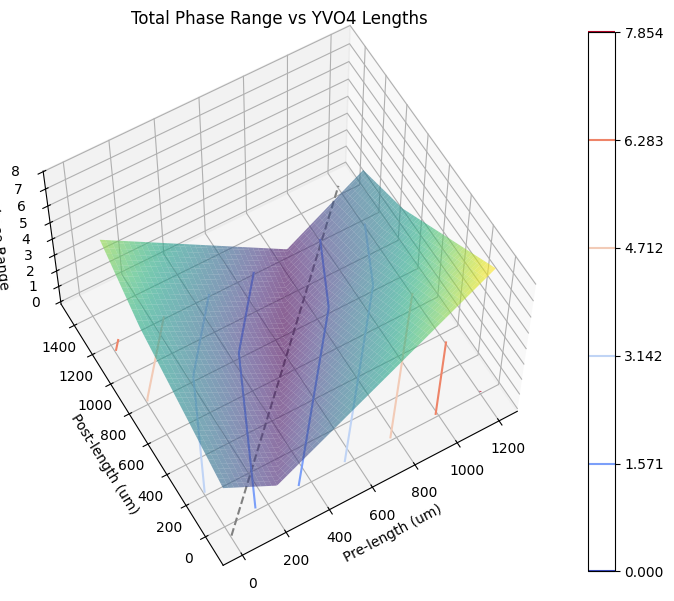

In [53]:
pre_length_range = np.linspace(0, 1.2e3, 200)
post_length_range = np.linspace(0, 1.2e3, 100)

range_data_X, range_data_Y = np.meshgrid(pre_length_range, post_length_range)
range_data_Z = np.zeros_like(range_data_X)

absolute_phase_data_Z = np.zeros_like(range_data_X)

# Generate data for 3D plot
pump_wavelengths = np.linspace(min_pump_wavelength, max_pump_wavelength, 10)
i_wavelengths = np.linspace(min_signal_wavelength, max_signal_wavelength, 1000)

for i, l_yvo_pre in enumerate(pre_length_range):
    for j, l_yvo_post in enumerate(post_length_range):

        X, Y = np.meshgrid(i_wavelengths, pump_wavelengths)
        Z = np.zeros_like(X)

        absolute_phase, wavelength_dependent_phase_range = get_phase_differences(
            pump_wavelengths=pump_wavelengths,
            i_wavelengths=i_wavelengths,
            a=a,
            b=b,
            aprime=aprime,
            bprime=bprime,
            l_yvo_pre=l_yvo_pre,
            L_BBO_PRE=L_BBO_PRE,
            L_BBO_POST=L_BBO_POST,
            l_yvo_post=l_yvo_post,
        )

        range_data_Z[j, i] = wavelength_dependent_phase_range

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(range_data_X, range_data_Y, range_data_Z, cmap="viridis", alpha=0.6)
ax.set_xlabel("Pre-length (um)")
ax.set_ylabel("Post-length (um)")
ax.set_zlabel("Total Phase Range")
ax.set_title("Total Phase Range vs YVO4 Lengths")

cset = ax.contour(
    range_data_X,
    range_data_Y,
    range_data_Z,
    levels=np.arange(0, range_data_Z.max(), np.pi / 2),
    cmap="coolwarm",
    offset=range_data_Z.min(),
)
fig.colorbar(cset)

# Plot the line for zero absolute phase difference
post_comp_lengths = np.polyval(coefficients, pre_length_range)
ax.plot(pre_length_range, post_comp_lengths, np.zeros_like(pre_length_range), color="grey", linestyle="--")

ax.view_init(60, 240)

plt.show()

# save the fig
fig.savefig("phase_difference_optimisation.png")

Minimum wavelength dependent phase range = 0.21 rad
Optimal pre-compensating crystal length = 554.77 um
Optimal post-compensating crystal length = 626.88 um


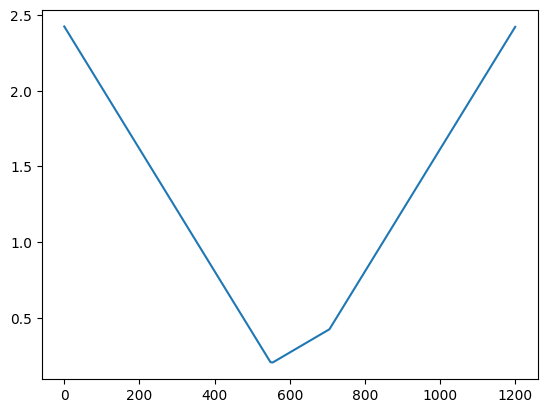

In [54]:
# Plot the wavelength dependent phase range for zero absolute phase difference
wavelength_dependent_phase_ranges = np.zeros_like(pre_length_range)

for i, pre_comp_length in enumerate(pre_length_range):
    post_comp_length = np.polyval(coefficients, pre_comp_length)
    absolute_phase, wavelength_dependent_phase_range = get_phase_differences(
        pump_wavelengths=pump_wavelengths,
        i_wavelengths=i_wavelengths,
        a=a,
        b=b,
        aprime=aprime,
        bprime=bprime,
        l_yvo_pre=pre_comp_length,
        L_BBO_PRE=L_BBO_PRE,
        L_BBO_POST=L_BBO_POST,
        l_yvo_post=post_comp_length,
    )
    
    wavelength_dependent_phase_ranges[i] = wavelength_dependent_phase_range

plt.plot(pre_length_range, wavelength_dependent_phase_ranges)

optimal_pre_length = pre_length_range[wavelength_dependent_phase_ranges.argmin()]
optimal_post_length = np.polyval(coefficients, optimal_pre_length)
minimum_wavelength_dependent_phase_range = wavelength_dependent_phase_ranges.min()

print(f"Minimum wavelength dependent phase range = {minimum_wavelength_dependent_phase_range:.2f} rad")
print(f"Optimal pre-compensating crystal length = {optimal_pre_length:.2f} um")
print(f"Optimal post-compensating crystal length = {optimal_post_length:.2f} um")

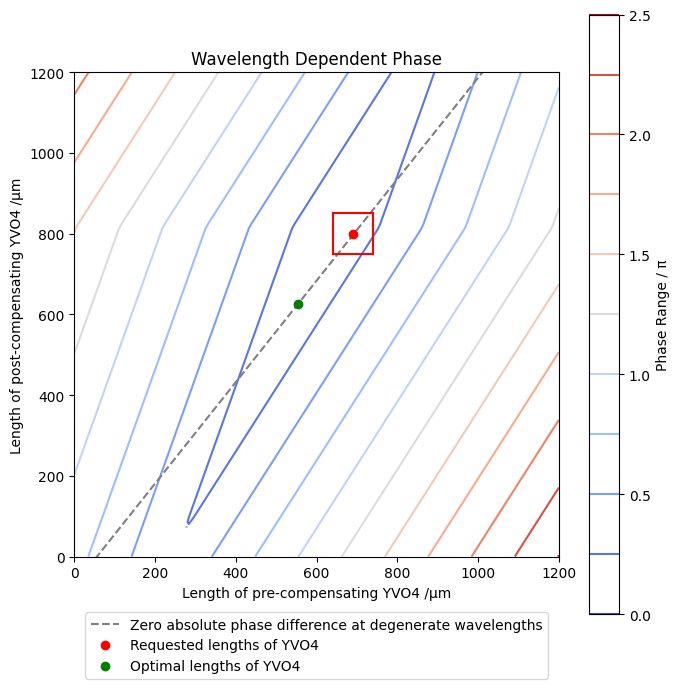

In [55]:
# plot just the 2d contour
plt.contour(
    range_data_X,
    range_data_Y,
    range_data_Z / np.pi,
    levels=np.arange(0, range_data_Z.max() / np.pi, 0.25),
    cmap="coolwarm",
)
plt.xlabel("Length of pre-compensating YVO4 /μm")
plt.ylabel("Length of post-compensating YVO4 /μm")
plt.title("Wavelength Dependent Phase")
# label the colourbar using the phase range / pi
cbar = plt.colorbar()
cbar.set_label("Phase Range / π")

# Plot the line for zero absolute phase difference
post_comp_lengths = np.polyval(coefficients, pre_length_range)
plt.plot(pre_length_range, post_comp_lengths, color="grey", linestyle="--", label="Zero absolute phase difference at degenerate wavelengths")

# set xlim
plt.xlim([pre_length_range.min(), pre_length_range.max()])
plt.ylim([post_length_range.min(), post_length_range.max()])
plt.gca().set_aspect("equal", adjustable="box")

# Add a red dot at the purchased lengths
plt.plot(purchased_length_pre, purchased_length_post, "ro", label="Requested lengths of YVO4")

# Add a red box around the red dot width = 50
plt.plot(
    [purchased_length_pre - 50, purchased_length_pre + 50],
    [purchased_length_post - 50, purchased_length_post - 50],
    "r",
)
plt.plot(
    [purchased_length_pre - 50, purchased_length_pre + 50],
    [purchased_length_post + 50, purchased_length_post + 50],
    "r",
)
plt.plot(
    [purchased_length_pre - 50, purchased_length_pre - 50],
    [purchased_length_post - 50, purchased_length_post + 50],
    "r",
    label="_hide",
)
plt.plot(
    [purchased_length_pre + 50, purchased_length_pre + 50],
    [purchased_length_post - 50, purchased_length_post + 50],
    "r",
)

# Add a green dot at the optimal point
plt.plot(optimal_pre_length, optimal_post_length, "go", label="Optimal lengths of YVO4")

# Position the legend like a caption beneath the x axis
plt.legend()
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1))

plt.gcf().set_size_inches(7, 7)

# save the fig with tight layout
plt.tight_layout()

plt.savefig("phase_difference_optimisation_contour.png")
plt.show()